# About Dataset
This dataset is originally from the National Institute of Diabetes and Digestive and Kidney
Diseases. The objective of the dataset is to diagnostically predict whether a patient has diabetes,
based on certain diagnostic measurements included in the dataset. Several constraints were placed
on the selection of these instances from a larger database. In particular, all patients here are females
at least 21 years old of Pima Indian heritage.2
From the data set in the (.csv) File We can find several variables, some of them are independent
(several medical predictor variables) and only one target dependent variable (Outcome).


In [5]:
import random

# Set a seed for the random number generator
random.seed(42)  # You can choose any integer as the seed

In [6]:
!pip install shap

In [7]:
# Libraries
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_val_predict
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.metrics import roc_auc_score,roc_curve
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler, RobustScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import mean_squared_error
from warnings import filterwarnings
import random
filterwarnings('ignore')


# DATASET

In [8]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.width', 500)

diabetes = pd.read_csv("diabetes.csv")
df = diabetes.copy()
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.600,0.627,50,1
1,1,85,66,29,0,26.600,0.351,31,0
2,8,183,64,0,0,23.300,0.672,32,1
3,1,89,66,23,94,28.100,0.167,21,0
4,0,137,40,35,168,43.100,2.288,33,1


# DATA PRE-PROCESSING

In [9]:
# Let's make variables's names smaller

df.columns = [col.lower() for col in df.columns]
df.head()

,pregnancies,glucose,bloodpressure,skinthickness,insulin,bmi,diabetespedigreefunction,age,outcome
0,6,148,72,35,0,33.600,0.627,50,1
1,1,85,66,29,0,26.600,0.351,31,0
2,8,183,64,0,0,23.300,0.672,32,1
3,1,89,66,23,94,28.100,0.167,21,0
4,0,137,40,35,168,43.100,2.288,33,1


In [10]:
def grab_col_names(dataframe, cat_th=10, car_th=20):
    """

   Returns the names of categorical, numeric and categorical but cardinal variables in the data set.
   Note Categorical variables include categorical variables with numeric appearance.

    Parameters
    ------
        dataframe: dataframe
                Dataframe to get variable names
        cat_th: int, optional
                class threshold for numeric but categorical variables
        car_th: int, optinal
                class threshold for categorical but cardinal variables

    Returns
    ------
        cat_cols: list
                Categorical variable list
        num_cols: list
                Numeric variable list
        cat_but_car: list
                List of cardinal variables with categorical view

    Examples
    ------
        import seaborn as sns
        df = sns.load_dataset("iris")
        print(grab_col_names(df))


    Notes
    ------
        cat_cols + num_cols + cat_but_car = total number of variables

        The sum of 3 lists with return equals the total number of variables: cat_cols + num_cols + cat_but_car = number of variables

    """

    # cat_cols, cat_but_car
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                   dataframe[col].dtypes != "O"]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                   dataframe[col].dtypes == "O"]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    # num_cols
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')
    return cat_cols, num_cols, cat_but_car

cat_cols, num_cols, cat_but_car = grab_col_names(df)

Observations: 768
Variables: 9
cat_cols: 1
num_cols: 8
cat_but_car: 0
num_but_cat: 1


In [11]:
df.head()

,pregnancies,glucose,bloodpressure,skinthickness,insulin,bmi,diabetespedigreefunction,age,outcome
0,6,148,72,35,0,33.600,0.627,50,1
1,1,85,66,29,0,26.600,0.351,31,0
2,8,183,64,0,0,23.300,0.672,32,1
3,1,89,66,23,94,28.100,0.167,21,0
4,0,137,40,35,168,43.100,2.288,33,1


In [12]:
# Outliers

def outlier_thresholds(dataframe, col_name, q1=0.15, q3=0.85):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + interquantile_range
    low_limit = quartile1 - 1.3 * interquantile_range
    return low_limit, up_limit



In [13]:
df.head()

,pregnancies,glucose,bloodpressure,skinthickness,insulin,bmi,diabetespedigreefunction,age,outcome
0,6,148,72,35,0,33.600,0.627,50,1
1,1,85,66,29,0,26.600,0.351,31,0
2,8,183,64,0,0,23.300,0.672,32,1
3,1,89,66,23,94,28.100,0.167,21,0
4,0,137,40,35,168,43.100,2.288,33,1


In [14]:
def check_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False

In [15]:
df.head()

,pregnancies,glucose,bloodpressure,skinthickness,insulin,bmi,diabetespedigreefunction,age,outcome
0,6,148,72,35,0,33.600,0.627,50,1
1,1,85,66,29,0,26.600,0.351,31,0
2,8,183,64,0,0,23.300,0.672,32,1
3,1,89,66,23,94,28.100,0.167,21,0
4,0,137,40,35,168,43.100,2.288,33,1


In [16]:
def grab_outliers(dataframe, col_name, index=False):
    low, up = outlier_thresholds(dataframe, col_name)

    if dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up))].shape[0] > 10:
        print(dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up))].head())
    else:
        print(dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up))])

    if index:
        outlier_index = dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up))].index
        return outlier_index

    for col in df.columns:
        print(col, grab_outliers(df,col))

In [17]:
df.head()

,pregnancies,glucose,bloodpressure,skinthickness,insulin,bmi,diabetespedigreefunction,age,outcome
0,6,148,72,35,0,33.600,0.627,50,1
1,1,85,66,29,0,26.600,0.351,31,0
2,8,183,64,0,0,23.300,0.672,32,1
3,1,89,66,23,94,28.100,0.167,21,0
4,0,137,40,35,168,43.100,2.288,33,1


In [18]:
def replace_with_thresholds(dataframe, variable):
        low_limit, up_limit = outlier_thresholds(dataframe, variable)
        dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
        dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

for col in num_cols:
        print(replace_with_thresholds(df, col))

None
None
None
None
None
None
None
None


In [19]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
pregnancies,768.000,3.842,3.360,0.000,1.000,3.000,6.000,15.000
glucose,768.000,120.937,31.816,6.500,99.000,117.000,140.250,199.000
bloodpressure,768.000,70.188,15.673,24.200,62.000,72.000,80.000,110.000
skinthickness,768.000,20.504,15.817,0.000,0.000,23.000,32.000,74.000
insulin,768.000,75.132,97.656,0.000,0.000,30.500,127.250,359.800
bmi,768.000,32.047,7.454,5.968,27.300,32.000,36.600,53.785
diabetespedigreefunction,768.000,0.463,0.296,0.078,0.244,0.372,0.626,1.321
age,768.000,33.224,11.700,21.000,24.000,29.000,41.000,70.000
outcome,768.000,0.349,0.477,0.000,0.000,0.000,1.000,1.000


In [20]:
# There are no missing observations in the dataset
# but for variables such as Glucose, Insulin, etc., observation units containing a value of 0 may represent a missing value.

variables = ["skinthickness", "insulin"]
df[variables] = df[variables].replace(0,np.NaN)
df.isnull().sum()

pregnancies                   0
glucose                       0
bloodpressure                 0
skinthickness               227
insulin                     374
bmi                           0
diabetespedigreefunction      0
age                           0
outcome                       0
dtype: int64

In [21]:
# Handle to missing value
# df["skinthickness"].fillna(df.groupby("outcome")["skinthickness"].transform("mean"), inplace=True)
df["insulin"].fillna(df.groupby('outcome')["insulin"].transform("mean"), inplace=True)
df.isnull().sum()

pregnancies                   0
glucose                       0
bloodpressure                 0
skinthickness               227
insulin                       0
bmi                           0
diabetespedigreefunction      0
age                           0
outcome                       0
dtype: int64

## Feature Engineering
future engineering is crucial for machine learning because it allows for the development of more advanced and efficient models that can handle larger and more complex datasets.

Machine learning is a rapidly evolving field, and new techniques and algorithms are being developed at an ever-increasing pace. Future engineering is essential for keeping up with these advances, as it involves developing new hardware and software technologies that can support more advanced machine learning models.

Future engineering also involves the development of software frameworks and libraries that can facilitate the development and deployment of machine learning models. For instance, Tensorflow and PyTorch are two widely used frameworks that provide a high-level interface for building and training machine learning models, making it easier for researchers and developers to create and deploy models.

Moreover, future engineering can help address some of the challenges facing machine learning, such as the need for more efficient algorithms and the ethical considerations surrounding AI. By developing new tools and techniques, we can better understand and control the behavior of machine learning models, leading to more reliable and trustworthy systems.

In summary, future engineering is essential for advancing machine learning, and it will play a critical role in shaping the future of AI.

In [22]:
df = df[['glucose', 'bloodpressure', 'insulin', 'bmi', 'diabetespedigreefunction','outcome']]

In [23]:
num_cols.remove('pregnancies')
num_cols.remove('skinthickness')
num_cols.remove('age')

In [24]:
# Now time to future scaling for numeric cols

rs = RobustScaler()
df[num_cols] = rs.fit_transform(df[num_cols])
df.head()


,glucose,bloodpressure,insulin,bmi,diabetespedigreefunction,outcome
0,0.752,0.000,0.946,0.172,0.665,1
1,-0.776,-0.333,0.000,-0.581,-0.056,0
2,1.600,-0.444,0.946,-0.935,0.783,1
3,-0.679,-0.333,-0.457,-0.419,-0.537,0
4,0.485,-1.778,0.628,1.194,2.480,1


# **Testing inverse scaler**

In [25]:
newdf = df.copy()
newdf[num_cols] = rs.inverse_transform(df[num_cols])

In [26]:
newdf.head()

,glucose,bloodpressure,insulin,bmi,diabetespedigreefunction,outcome
0,148.000,72.000,189.692,33.600,0.627,1
1,85.000,66.000,125.155,26.600,0.351,0
2,183.000,64.000,189.692,23.300,0.672,1
3,89.000,66.000,94.000,28.100,0.167,0
4,137.000,40.000,168.000,43.100,1.321,1


## PREDICTION

### Light GBM

In [ ]:
y = df["outcome"]
X = df.drop(["outcome"], axis=1)
X_train, X_test, y_train, y_test  = train_test_split(X, y, test_size=0.20, random_state=42)


lgbm = LGBMClassifier(learning_rate=0.01, max_depth=3, subsample=0.6, n_estimators=1000, min_child_samples=10)
lgbm_model = lgbm.fit(X_train, y_train)
y_pred = lgbm_model.predict(X_test)
accuracy_score(y_test, y_pred)

In [28]:
X.columns

Index(['glucose', 'bloodpressure', 'insulin', 'bmi', 'diabetespedigreefunction'], dtype='object')

In [29]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 154 entries, 668 to 462
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   glucose                   154 non-null    float64
 1   bloodpressure             154 non-null    float64
 2   insulin                   154 non-null    float64
 3   bmi                       154 non-null    float64
 4   diabetespedigreefunction  154 non-null    float64
dtypes: float64(5)
memory usage: 7.2 KB


In [30]:
# explainer = shap.TreeExplainer(model, data=X_train)
# shap_values = explainer.shap_values(X_test, check_additivity=False)


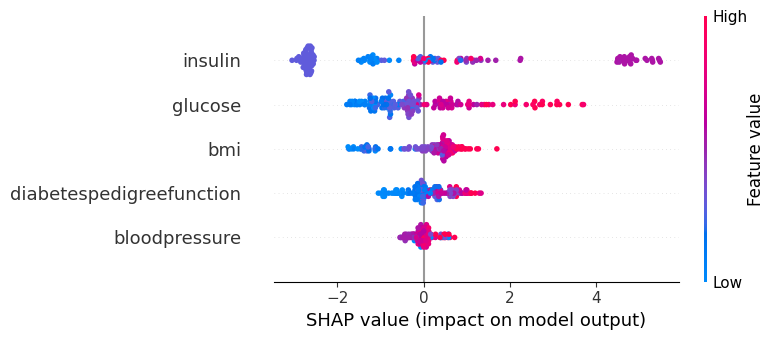

In [31]:
import shap
explainer = shap.TreeExplainer(lgbm_model, X_train)

# Calculate SHAP values for the test data
shap_values = explainer.shap_values(X_test, check_additivity=False)

# Create a summary plot for feature importance across all predictions
shap.summary_plot(shap_values, X_test, feature_names=X.columns)

In [32]:
X_test_ID = X_test.copy()
X_test_ID['ID'] = [i for i in range(1, len(X_test)+1)]

In [33]:
#shap_values = explainer(X_test)

# Create a DataFrame with SHAP values and 'ID' as a separate column
shap_df = pd.DataFrame(shap_values, columns=X_test.columns)

shap_df['ID'] = list(X_test_ID['ID'])
class_probabilities = lgbm_model.predict_proba(X_test)[:, 1]
predicted_labels = lgbm_model.predict(X_test)
shap_df['prediction'] = predicted_labels
shap_df['class_prob'] = class_probabilities

In [34]:
shap_df.head()

,glucose,bloodpressure,insulin,bmi,diabetespedigreefunction,ID,prediction,class_prob
0,-0.775,-0.533,2.252,0.557,-0.002,1,0,0.441
1,-0.403,0.026,-2.698,0.462,-0.925,2,0,0.005
2,-0.397,0.005,-2.778,0.243,-0.941,3,0,0.004
3,-0.184,0.063,-2.717,-1.361,1.004,4,0,0.007
4,0.798,0.507,-2.797,0.323,0.057,5,0,0.055


In [35]:
X_test['outcome'] = y_test
X_test_n = X_test.copy()
X_test_n[num_cols] = rs.inverse_transform(X_test[num_cols])

In [36]:
X_test_n['ID'] = [i for i in range(1, len(X_test)+1)]

In [37]:
# Set a fixed seed for reproducibility
random_state = 42

# Separate examples by class
class_0_examples = X_test_n[X_test_n['outcome'] == 0]
class_1_examples = X_test_n[X_test_n['outcome'] == 1]

# Select 13 examples labeled as '1' and 12 examples labeled as '0'
X_test_llm = pd.concat([class_0_examples.sample(12, random_state=random_state),
                        class_1_examples.sample(13, random_state=random_state)])

# The random_state parameter ensures consistent sampling


In [38]:
shap_df_llm = shap_df[shap_df['ID'].isin(X_test_llm['ID'])]

In [39]:
num_cols

['glucose', 'bloodpressure', 'insulin', 'bmi', 'diabetespedigreefunction']

In [40]:
def getPrompts():
    prompt1 = """Hello! We are using natural language to interface with a machine-learning medical model, aiming to make complex algorithmic predictions accessible and understandable to patients. Our model is a Logistic Regression that predicts the likelihood of diabetes diagnosis based on vital patient data. Please explain how the model works in simple terms and provide specific numerical lifestyle suggestions based on the model's output. The model uses these features: ['glucose', 'blood pressure', 'insulin', 'BMI', 'diabetes pedigree function']. Prediction probability ranges from 0 (No Diabetes) to 1 (Diabetes): """

    prompt2 = """ The patient's feature values are: """

    prompt3 = """ The SHAP values, showing the impact of each feature on the prediction, are: """

    prompt4 = """ Question from the patient: """

    return prompt1, prompt2, prompt3, prompt4


def generate_final_prompt(prob, feature_values, shap_values, ques):
    prompt1, prompt2, prompt3, prompt4 = getPrompts()
    prompt = (
        prompt1 + str(prob) +
        prompt2 + str(feature_values) +
        prompt3 + str(shap_values) +
        prompt4 +
        ques[0] +
        ques[1]
    )
    return prompt


In [41]:
question_list_high_risk = [
                           [""" What specific changes should I make to my lifestyle to reduce my risk of diabetes? Please provide numerical targets for changes.""",""" Based on the model's predictions and the SHAP values, please suggest specific numerical changes to the two most impactful features. Format your suggestions as follows: 'Feature: [Feature Name], Suggested Change: [Exact Numerical Value]' Your Answer: """],
                           [""" How would a change in BMI (or/and, 'glucose', 'bloodpressure', 'insulin', 'diabetespedigreefunction') affect this risk score?""",""" Based on the model's predictions and the SHAP values, please suggest specific numerical changes to the two most impactful features. Format your suggestions as follows: 'Feature: [Feature Name], Suggested Change: [Exact Numerical Value]' Your Answer: """],
                           ["""Why is the risk score so high?""",""" Your Answer:"""]]

In [42]:
question_list_low_risk = [
                          [""" Are there specific lifestyle changes I can make to maintain this low risk? """,""" Based on the model's predictions and the SHAP values, please suggest specific numerical changes to the two most impactful features. Format your suggestions as follows: 'Feature: [Feature Name], Suggested Change: [Exact Numerical Value]' Your Answer: """],
                          [""" How would a change in BMI (or/and, 'glucose', 'bloodpressure', 'insulin', 'diabetespedigreefunction') affect this risk score?""",""" Based on the model's predictions and the SHAP values, please suggest specific numerical changes to the two most impactful features. Format your suggestions as follows: 'Feature: [Feature Name], Suggested Change: [Exact Numerical Value]' Your Answer: """],
                          [""" What factors contributed to my low risk of diabetes? """,""" Your Answer:"""]]

In [43]:
prompt_entries = []
for index, row in shap_df_llm.iterrows():
  shap_values = list(row[['glucose', 'bloodpressure', 'insulin', 'bmi', 'diabetespedigreefunction']])
  features= X_test_llm[X_test_llm['ID'] == row['ID']].iloc[0]
  features_values = list(features[['glucose', 'bloodpressure', 'insulin', 'bmi', 'diabetespedigreefunction']])
  pred = row['class_prob']
  if pred>=0.5:
    question_list = question_list_high_risk
  else:
    question_list = question_list_low_risk
  for idx, ques in enumerate(question_list):
    prompt = generate_final_prompt(pred,features_values,shap_values,ques).replace("\n", "")
    prompt_entries.append([row['ID'], prompt])

In [106]:
df_prompts = pd.DataFrame(prompt_entries, columns=['ID', 'Prompt'])

# **Reshaping**

In [ ]:
df_prompts

In [108]:
df_prompts['sort_index'] = df_prompts.index % 3
df_sorted = df_prompts.sort_values(by=['sort_index']).reset_index(drop=True)

In [109]:
df_sorted.to_csv('PromptsOutput.csv', index=False)

# LLM Inference

Given Prompt,  infers Llama 2  7b

In [ ]:
!pip install -qU \
  transformers==4.31.0 \
  sentence-transformers==2.2.2 \
  pinecone-client==2.2.2 \
  datasets==2.14.0 \
  accelerate==0.21.0 \
  einops==0.6.1 \
  langchain==0.0.240 \
  xformers==0.0.20 \
  bitsandbytes==0.41.0

In [73]:
from torch import cuda, bfloat16
import transformers

model_id = 'NousResearch/Llama-2-7b-chat-hf'

device = f'cuda:{cuda.current_device()}' if cuda.is_available() else 'cpu'
bnb_config = transformers.BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type='nf4',
    bnb_4bit_use_double_quant=True,
    bnb_4bit_compute_dtype=bfloat16
)

hf_auth = 'HF_AUTH_TOKEN'
model_config = transformers.AutoConfig.from_pretrained(
    model_id,
    use_auth_token=hf_auth
)

model = transformers.AutoModelForCausalLM.from_pretrained(
    model_id,
    trust_remote_code=True,
    config=model_config,
    quantization_config=bnb_config,
    device_map='auto',
    use_auth_token=hf_auth
)
model.eval()
print(f"Model loaded on {device}")
tokenizer = transformers.AutoTokenizer.from_pretrained(
    model_id,
    use_auth_token=hf_auth
)
generate_text = transformers.pipeline(
    model=model, tokenizer=tokenizer,
    return_full_text=True,  
    task='text-generation',
    temperature=0.0, 
    max_new_tokens=1024, 
    repetition_penalty=1.1 
)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Model loaded on cuda:0


In [ ]:
from tqdm import tqdm
def execute_llm_query(text):
    res = generate_text(text+"\n")
    return f"{res[0]['generated_text']}" 

new_df = pd.DataFrame(columns=['ID', 'Prompt', 'sort_index', 'Generated_Text_llama7b'])

tqdm_pandas = tqdm(total=len(df_sorted), position=0, leave=True)

for index, row in df_sorted.iterrows():

    generated_text = execute_llm_query(row['Prompt'])
    print(generated_text)
    new_df = new_df.append({
        'ID': row['ID'],
        'Prompt': row['Prompt'],
        'sort_index': row['sort_index'],
        'Generated_Text_llama7b': generated_text
    }, ignore_index=True)

    new_df.to_csv("/content/drive/MyDrive/Med277/Llama inference/progress_datagenerated_text_llama7b.csv", index=False)
    tqdm_pandas.update(1)

tqdm_pandas.close()


# Applying LLM suggestions

This block applies suggestions by Llama2 to input features and computes probability of classes

In [1]:
!pip install openai

In [3]:
import pandas as pd
results_ = pd.read_csv('/content/drive/MyDrive/Med277/Llama inference/suggestions_by_llama7b.csv')

In [4]:
import os
os.environ["OPENAI_API_KEY"] = "<Your OPENAI API Key>"

In [10]:
import asyncio
from openai import AsyncOpenAI
def generate_extraction_prompt(model_output):
    # Extracting the section containing the model's suggestions
    suggestion_marker = "Suggested Change: [Exact Numerical Value]'"
    suggestion_start = model_output.find(suggestion_marker)

    # Adjusting the start index to skip the marker text
    if suggestion_start != -1:
        suggestion_start += len(suggestion_marker)
        suggestion_text = model_output[suggestion_start:]
    else:
        suggestion_text = "No specific suggestions found."
    # Extracting the section containing the original feature values
    feature_values_start = model_output.find("feature values are: ")
    feature_values_end = model_output.find("The SHAP values, showing ")

    feature_values_text = model_output[feature_values_start:feature_values_end] if feature_values_start != -1 else "Original feature values not found."

    # Constructing the prompt with the extracted information
    prompt = f"""I have received advice from a machine learning model about changes that should be made to a patient's lifestyle to reduce their risk of diabetes. The advice includes the patient's original feature values and the suggested changes. Here are the details:


Model's Suggestions is\"\"\"
{suggestion_text}
\"\"\"

Original {feature_values_text}

Note: The features used in the model are ['glucose', 'blood pressure', 'insulin', 'BMI', 'diabetes pedigree function']. Ensure that the final feature list reflects the changes as suggested by the model and maintains the same order as the original features.

Based on this information, please extract the specific changes recommended for each feature and update the original feature values accordingly. Create a final, adjusted feature list that incorporates these changes. Format your response as follows:
'Final_Feature_List:  ['adjusted glucose', 'adjusted blood pressure', 'adjusted insulin', 'adjusted BMI', 'adjusted diabetes pedigree function']'
What is Final_Feature_List containing only numerical values?
"""

    return prompt
response =[]
async def apply_model_suggestions(model_output,client):
  prompt = generate_extraction_prompt(model_output)
  completion = await client.chat.completions.create(model="gpt-3.5-turbo",messages=[{"role": "user","content":prompt}], temperature=0.0)
  response = completion.choices[0].message.content

  return response


client = AsyncOpenAI()


# results = results_.iloc[0]["Generated_Text_llama7b"]
# for idx,
# await apply_model_suggestions(results,client)


In [ ]:
suggested_df = pd.DataFrame(columns=['ID', 'Prompt', 'sort_index', 'Generated_Text_llama7b',"suggestion_vals"])
for index, row in results_.iterrows():
  generated_text = row['Generated_Text_llama7b']

  # Call apply_model_suggestions() with the generated_text
  suggestion_vals = await apply_model_suggestions(generated_text,client)  # Replace with your actual function

  # Create a new DataFrame with the values from the current row and the suggestion_vals
  new_row = {
      'ID': row['ID'],
      'Prompt': row['Prompt'],
      'sort_index': row['sort_index'],
      'Generated_Text_llama7b': generated_text,
      'suggestion_vals': suggestion_vals
  }

  # Append the new_row to suggested_df
  suggested_df = suggested_df.append(new_row, ignore_index=True)

In [13]:
suggested_df.to_csv('/content/drive/MyDrive/Med277/Llama inference/suggestions_by_llama7b_3.csv', index=False)

In [ ]:
import pandas as pd
import re

# Read the CSV file into a Pandas DataFrame
df = pd.read_csv('/content/drive/MyDrive/Med277/Llama inference/suggestions_by_llama7b_3.csv')

# Function to extract numerical list from a string
def extract_numerical_list(input_string):
    match = re.search(r'\[([\d\s.,]+)\]', input_string)
    print(match)
    if match:
        return [float(val) for val in match.group(1).split(',')]
    else:
        return []

# Apply the extract_numerical_list function to the desired column
df['Numerical_List'] = df['suggestion_vals'].apply(extract_numerical_list)

# Save the DataFrame with the new column back to a CSV file if needed
df.to_csv('/content/drive/MyDrive/Med277/Llama inference/suggestions_by_llama7b_4.csv', index=False)


# Compute final probability

In [44]:
import pandas as pd
suggest_ = pd.read_csv('/content/suggestions_by_llama7b_4.csv')

In [52]:

import ast
data_to_scale = np.array(suggest_['Numerical_List'].tolist())
scaled_data = rs.transform(data_to_scale)
predictions = lgbm_model.predict_proba(scaled_data)[:, 1]
suggest_['predictions'] = predictions

In [ ]:
suggest_['ID'] = suggest_['ID'].astype(int)
predictions_original = lgbm_model.predict_proba(X_test_ID[num_cols])[:, 1]
X_test_ID["original_class_prob"] = predictions_original
newdf = X_test_ID.copy()
newdf[num_cols] = rs.inverse_transform(X_test_ID[num_cols])
newdf['ID'] = newdf['ID'].astype(int)

# Merge the DataFrames on the 'ID' column
suggest_merged = pd.merge(suggest_, newdf[['ID', 'original_class_prob']], on='ID', how='left')


In [91]:
columns = ['glucose', 'bloodpressure', 'insulin', 'bmi', 'diabetespedigreefunction']
newdf['original_vals'] = newdf[columns].values.tolist()
temp_df = newdf[['ID', 'original_vals']]
temp_df['ID'] = temp_df['ID'].astype(suggest_merged['ID'].dtype)
suggest_merged = pd.merge(suggest_merged, temp_df, on='ID', how='left')

In [93]:
suggest_merged.to_csv('/content/drive/MyDrive/Med277/Llama inference/Final_Predictions_by_llama7b_4.csv', index=False)
